<a href="https://colab.research.google.com/github/mmdreza-ghorbani/Thesis_codes/blob/main/Create_climatological_map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import libraries and Data

### import madules

In [ ]:
!pip install geopandas
!pip install pykrige
!pip install rasterio
!pip install pyidw
!pip install pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 67.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 852.6/852.6 kB 11.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 23.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for pyidw: filename=pyidw-0.2.20-py3-none-any.whl size=10357 sha256=a3e91374b1952549a093b712600c4499667b4

### Import libraries

In [ ]:

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pykrige.ok import OrdinaryKriging
import rasterio
import rasterio.mask
from rasterio.plot import show
from rasterio.transform import Affine
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import box
from shapely.geometry import Polygon, Point
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

connect to Gdrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import and get mean of Data

In [ ]:
ClimatologyURL='/content/drive/My Drive/Climatology/'
def getmeanofData(stationName):
  df = pd.read_csv(ClimatologyURL + stationName + '.csv', encoding='utf-8-sig')
  df['data'] = pd.DatetimeIndex(df['data'])
  df.set_index('data',inplace = True)
  df = df.sort_index()
  df.drop(df[[ 'Unnamed: 0','station_name','region_id','region_name']], axis=1, inplace=True)
  df.astype(float)
  return df[:'2022-05-26 21:00:00'].mean().dropna()
  #return df[:'2022-05-28 21:00:00'].mean().dropna()

In [ ]:
Chitgar = getmeanofData('Chitgar')
Abali = getmeanofData('Abali')
Firouzkuh = getmeanofData('Firouzkuh')
Damavand = getmeanofData('Damavand')
Geophisyc = getmeanofData('Geophisyc')
FirouzkuhGow = getmeanofData('FirouzkuhGow')
ImamKhomeini = getmeanofData('ImamKhomeini')
Lavasan = getmeanofData('Lavasan')
Shahriar = getmeanofData('Shahriar')
Shemiran = getmeanofData('Shemiran')
Varamin = getmeanofData('Varamin')
#test = getmeanofData('Test')
FirouzkuhGow = getmeanofData('FirouzkuhGow')

## Create Geopandas Data

In [ ]:
ShapefileUrl='/content/drive/My Drive/ShapeFiles/'
newcounties = gpd.read_file(ShapefileUrl+"Mahalat.shp")
counties = gpd.read_file(ShapefileUrl+"NDVI_EXTEND.shp")

df = pd.read_excel(ClimatologyURL + 'Statistical course of Tehran stations.xlsx')
ClimatologyStationGDF = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))

In [ ]:
proj = 'epsg:4326'
ClimatologyStationGDF = ClimatologyStationGDF.set_crs(proj)
ClimatologyStationGDF.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
proj = 'epsg:32639'
ClimatologyStationGDF = ClimatologyStationGDF.to_crs(proj)
ClimatologyStationGDF.crs

<Projected CRS: EPSG:32639>
Name: WGS 84 / UTM zone 39N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 48°E and 54°E, northern hemisphere between equator and 84°N, onshore and offshore. Azerbaijan. Bahrain. Islamic Republic of Iran. Iraq. Kazakhstan. Kuwait. Oman. Qatar. Russian Federation. Saudi Arabia. Somalia. Turkmenistan. United Arab Emirates. Yemen.
- bounds: (48.0, 0.0, 54.0, 84.0)
Coordinate Operation:
- name: UTM zone 39N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
URL='/content/drive/My Drive/ShapeFiles/'
Polutions = gpd.read_file(URL+"polut.shp")

In [ ]:
Polutions = Polutions.to_crs(proj)
Polutions.crs

<Projected CRS: EPSG:32639>
Name: WGS 84 / UTM zone 39N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 48°E and 54°E, northern hemisphere between equator and 84°N, onshore and offshore. Azerbaijan. Bahrain. Islamic Republic of Iran. Iraq. Kazakhstan. Kuwait. Oman. Qatar. Russian Federation. Saudi Arabia. Somalia. Turkmenistan. United Arab Emirates. Yemen.
- bounds: (48.0, 0.0, 54.0, 84.0)
Coordinate Operation:
- name: UTM zone 39N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

plot map

Text(0.5, 1.0, 'Tehran Metropolitan - Climatology Measurement Locations')

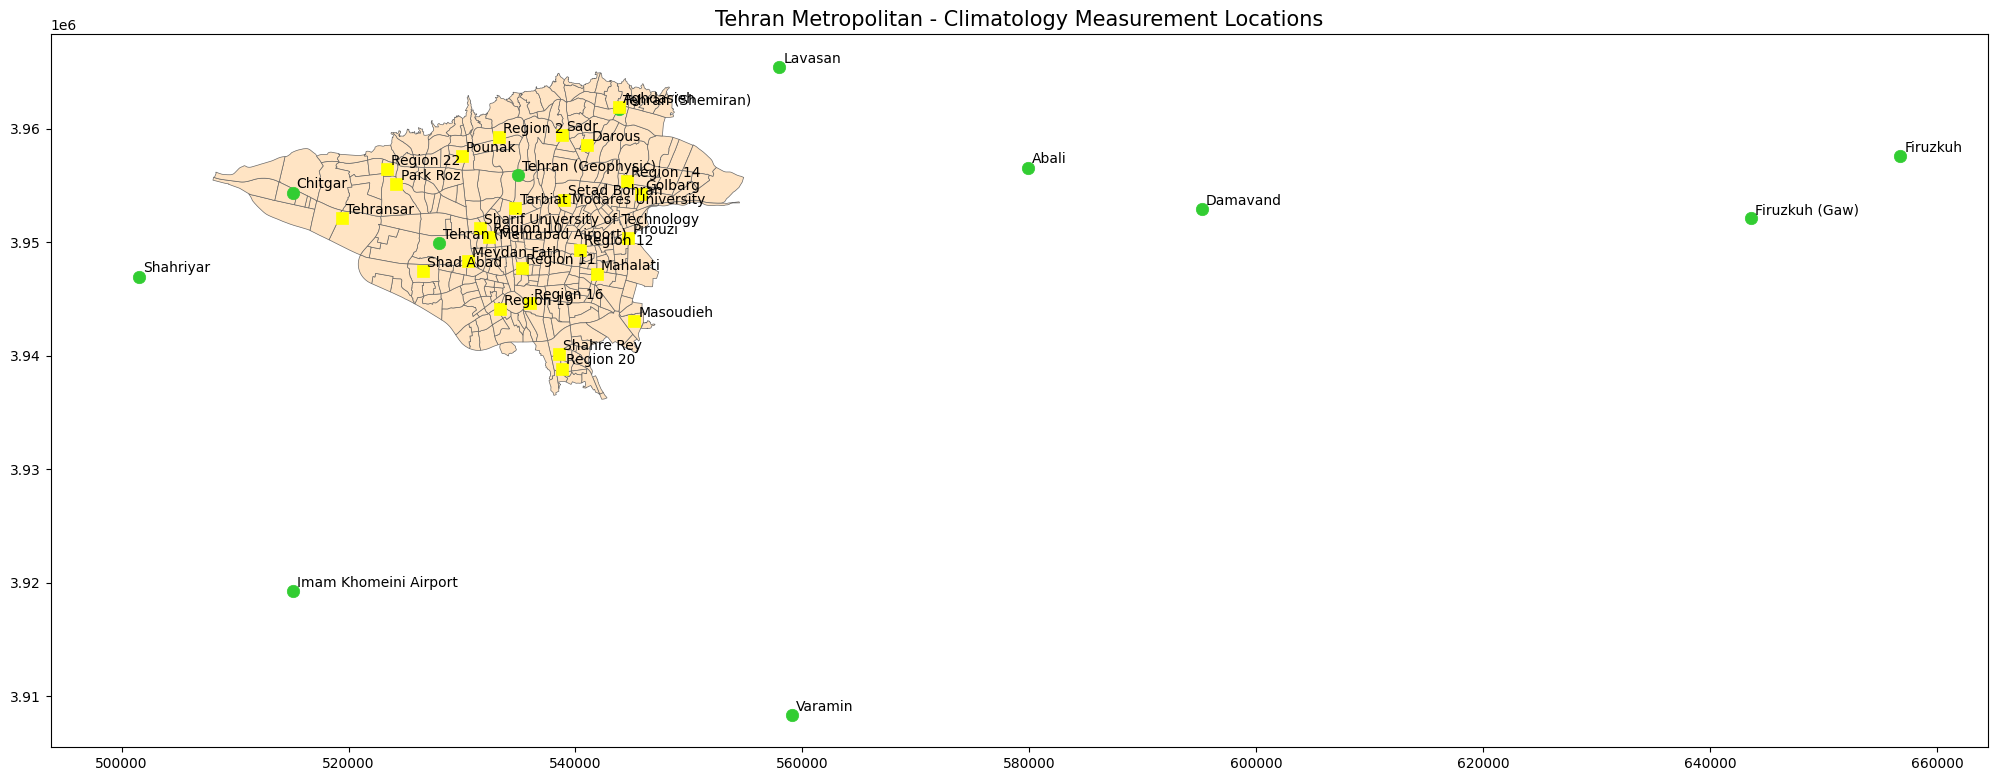

In [ ]:
import matplotlib.pyplot as plt
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (25, 20))

# Stylize plots
plt.style.use('bmh')

# Plot data
newcounties.plot(ax = ax, color = 'bisque', edgecolor = 'dimgray')
ClimatologyStationGDF.plot(ax = ax, marker = 'o', color = 'limegreen', markersize =80)
for x, y, label in zip(ClimatologyStationGDF.geometry.x, ClimatologyStationGDF.geometry.y, ClimatologyStationGDF.Station_name):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
Polutions.plot(ax = ax, marker = 's', color = 'yellow', markersize =80)
for x, y, label in zip(Polutions.geometry.x, Polutions.geometry.y, Polutions.ename):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
# Set title
ax.set_title('Tehran Metropolitan - Climatology Measurement Locations', fontdict = {'fontsize': '15', 'fontweight' : '3'})

create Datafram and merge all data in in that Dataframe

In [ ]:
#climatologyDF = pd.concat([Chitgar, Abali, Firouzkuh , Damavand, Geophisyc,FirouzkuhGow,ImamKhomeini,Lavasan,Shahriar,Shemiran,Varamin], axis=1)
climatologyDF = pd.concat([Chitgar, Abali, Damavand, Geophisyc,ImamKhomeini,Lavasan,Shahriar,Shemiran,Varamin], axis=1)

climatologyDF.columns = climatologyDF.iloc[0].astype(int)
climatologyDF = climatologyDF.iloc[1: , :]
climatologyDF = climatologyDF.dropna()
climatologyDF.reset_index(inplace=True)
climatologyDF = climatologyDF.transpose()
climatologyDF.columns = climatologyDF.iloc[0]
climatologyDF = climatologyDF.iloc[1: , :]
climatologyDF.astype(float)
display(climatologyDF)

index                 h            vv         n          dd        ff  \
station_id                                                              
99320            2500.0        8500.0       0.0  135.556653  1.968063   
40755       1681.246795  11519.660024  2.756861  131.130374  2.333651   
99369        1716.41833  12993.003653  2.508294   176.19027  1.676825   
99331            2500.0   9307.692308       0.0  139.719072  1.569652   
40777       1994.182631   9624.194571  2.312107  217.755261  4.075978   
99366       1758.520599   9427.416357  2.237918  181.999602  2.064626   
99375       1816.144549   9456.520133  2.667939  191.708366  3.042703   
40751       1940.634441   9572.300223  2.492487   83.865914  0.991712   
99406       2077.867101   9369.424094  1.932743  132.218406  1.991187   

index               t        td          p0       rrr          u       tmin  \
station_id                                                                    
99320       18.153316  0.495385  869.988947  0.164221  36.929361  13.091555   
40755        8.780789 -3.502224  758.883912  0.376931  49.032482   4.399021   
99369       11.316994 -1.187518  797.706946  0.292289  46.845354   6.175969   
99331       16.879004  -0.37102  858.564565  0.177795  37.193029  12.172086   
40777       17.982278  0.877172  902.609705  0.116862  39.822372  11.368189   
99366       13.069947 -0.584172  816.439637  0.327201   44.54089   9.079672   
99375       17.766865  2.385571  883.667737  0.241749  42.597227  11.643626   
40751       16.136334  1.252946  845.629336  0.315525  42.664563  10.819278   
99406       19.920338  4.557398  907.449389  0.189241  43.695465  11.193527   

index            tmax     radglo24       twet    ff_max      dd_max  \
station_id                                                            
99320       23.517732  2701.635933   9.578619  6.415474  210.885003   
40755       14.032847  2616.713333   3.372868  8.147164  181.139499   
99369       17.362323   1423.75406   5.665776  8.113703  237.014577   
99331       22.308918  2411.074155   8.694659  7.376617  201.107087   
40777       25.111578  2143.989659   9.703076  7.761547   255.18797   
99366       18.996776  2294.831169   6.797984  8.180659   249.22423   
99375        23.40999   770.779661  10.043106  7.572314  258.605372   
40751       22.227617  1724.826415   8.719563  6.279874  194.454927   
99406        26.01876   1902.91018  11.763276  8.262582  211.115974   

index         ff_gust     dd_gust  
station_id                         
99320       13.647059  234.705882  
40755            18.5        72.0  
99369        9.821053  248.473684  
99331        9.231061  223.257576  
40777       15.102041  284.897959  
99366       12.082353  221.411765  
99375             9.0        10.0  
40751        9.527845  212.227603  
99406       11.968254  208.730159

In [ ]:
climatologyGDF = gpd.GeoDataFrame(
    climatologyDF, geometry=ClimatologyStationGDF.set_index('Station_id').geometry)
display(climatologyGDF)

index                 h            vv         n          dd        ff  \
station_id                                                              
99320            2500.0        8500.0       0.0  135.556653  1.968063   
40755       1681.246795  11519.660024  2.756861  131.130374  2.333651   
99369        1716.41833  12993.003653  2.508294   176.19027  1.676825   
99331            2500.0   9307.692308       0.0  139.719072  1.569652   
40777       1994.182631   9624.194571  2.312107  217.755261  4.075978   
99366       1758.520599   9427.416357  2.237918  181.999602  2.064626   
99375       1816.144549   9456.520133  2.667939  191.708366  3.042703   
40751       1940.634441   9572.300223  2.492487   83.865914  0.991712   
99406       2077.867101   9369.424094  1.932743  132.218406  1.991187   

index               t        td          p0       rrr          u       tmin  \
station_id                                                                    
99320       18.153316  0.495385  869.988947  0.164221  36.929361  13.091555   
40755        8.780789 -3.502224  758.883912  0.376931  49.032482   4.399021   
99369       11.316994 -1.187518  797.706946  0.292289  46.845354   6.175969   
99331       16.879004  -0.37102  858.564565  0.177795  37.193029  12.172086   
40777       17.982278  0.877172  902.609705  0.116862  39.822372  11.368189   
99366       13.069947 -0.584172  816.439637  0.327201   44.54089   9.079672   
99375       17.766865  2.385571  883.667737  0.241749  42.597227  11.643626   
40751       16.136334  1.252946  845.629336  0.315525  42.664563  10.819278   
99406       19.920338  4.557398  907.449389  0.189241  43.695465  11.193527   

index            tmax     radglo24       twet    ff_max      dd_max  \
station_id                                                            
99320       23.517732  2701.635933   9.578619  6.415474  210.885003   
40755       14.032847  2616.713333   3.372868  8.147164  181.139499   
99369       17.362323   1423.75406   5.665776  8.113703  237.014577   
99331       22.308918  2411.074155   8.694659  7.376617  201.107087   
40777       25.111578  2143.989659   9.703076  7.761547   255.18797   
99366       18.996776  2294.831169   6.797984  8.180659   249.22423   
99375        23.40999   770.779661  10.043106  7.572314  258.605372   
40751       22.227617  1724.826415   8.719563  6.279874  194.454927   
99406        26.01876   1902.91018  11.763276  8.262582  211.115974   

index         ff_gust     dd_gust                        geometry  
station_id                                                         
99320       13.647059  234.705882  POINT (515071.685 3954384.682)  
40755            18.5        72.0  POINT (579864.260 3956580.080)  
99369        9.821053  248.473684  POINT (595201.337 3952935.313)  
99331        9.231061  223.257576  POINT (534960.549 3955919.596)  
40777       15.102041  284.897959  POINT (515131.120 3919264.160)  
99366       12.082353  221.411765  POINT (557975.979 3965471.907)  
99375             9.0        10.0  POINT (501508.423 3946978.071)  
40751        9.527845  212.227603  POINT (543847.877 3961751.285)  
99406       11.968254  208.730159  POINT (559084.585 3908354.865)

In [ ]:
proj = 'epsg:32639'
climatologyGDF = climatologyGDF.set_crs(proj)
climatologyGDF.crs

<Projected CRS: EPSG:32639>
Name: WGS 84 / UTM zone 39N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 48°E and 54°E, northern hemisphere between equator and 84°N, onshore and offshore. Azerbaijan. Bahrain. Islamic Republic of Iran. Iraq. Kazakhstan. Kuwait. Oman. Qatar. Russian Federation. Saudi Arabia. Somalia. Turkmenistan. United Arab Emirates. Yemen.
- bounds: (48.0, 0.0, 54.0, 84.0)
Coordinate Operation:
- name: UTM zone 39N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
climatologyGDF.to_file(ShapefileUrl+"climatologyMean.shp")

## Prepare Data

In [ ]:
# Create a copy of counties dataset
counties_dissolved = counties.copy()

# Add a field with constant value of 1
counties_dissolved["constant"] = 1

# Dissolve all counties to create one polygon
counties_dissolved = counties_dissolved.dissolve(by = "constant").reset_index(drop = True)

get coordinates and BB

In [ ]:
# Get X and Y coordinates of rainfall points
x_climatology = climatologyGDF["geometry"].x
y_climatology = climatologyGDF["geometry"].y

# Create list of XY coordinate pairs
coords_climatology = [list(xy) for xy in zip(x_climatology, y_climatology)]

# Get extent of counties feature
min_x_counties, min_y_counties, max_x_counties, max_y_counties = counties.total_bounds



Create for Export and Import Tif File

In [ ]:
def export_kde_raster(Z, XX, YY, min_x, max_x, min_y, max_y, proj, filename):
    '''Export and save a kernel density raster.'''

    # Get resolution
    xres = (max_x - min_x) / len(XX)
    yres = (max_y - min_y) / len(YY)

    # Set transform
    transform = Affine.translation(min_x - xres / 2, min_y - yres / 2) * Affine.scale(xres, yres)

    # Export array as raster
    with rasterio.open(
            filename,
            mode = "w",
            driver = "GTiff",
            height = Z.shape[0],
            width = Z.shape[1],
            count = 1,
            dtype = Z.dtype,
            crs = proj,
            transform = transform,
    ) as new_dataset:
            new_dataset.write(Z, 1)

In [ ]:
# Get list of airpolution "values"
variableName ='ff_gust'
#variableName = climatologyDF.columns[0]
value_climatology = list(climatologyGDF[variableName])

# start interpolation

create train and test split

In [ ]:

# Split data into testing and training sets
coords_climatology_train, coords_climatology_test, value_climatology_train, value_climatology_test = train_test_split(coords_climatology, value_climatology, test_size = 0.20, random_state = 0)

# Create separate GeoDataFrames for testing and training sets
climatology_train_gdf = gpd.GeoDataFrame(geometry = [Point(x, y) for x, y in coords_climatology_train], crs = proj)
climatology_train_gdf["Actual_Value"] = value_climatology_train
climatology_test_gdf = gpd.GeoDataFrame(geometry = [Point(x, y) for x, y in coords_climatology_test], crs = proj)
climatology_test_gdf["Actual_Value"] = value_climatology_test

# Get minimum and maximum coordinate values of training points
min_x_climatology, min_y_climatology, max_x_climatology, max_y_climatology = climatology_train_gdf.total_bounds

In [ ]:

# Set projection to WGS 84 and reproject data
proj_wgs = proj
counties_wgs = counties.to_crs(proj_wgs)
climatologyGDF_wgs = climatologyGDF.to_crs(proj_wgs)
climatology_train_gdf_wgs = climatology_train_gdf.to_crs(proj_wgs)
climatology_test_gdf_wgs = climatology_test_gdf.to_crs(proj_wgs)

# Get X and Y coordinates of airpolution points
x_climatology_wgs = climatologyGDF_wgs["geometry"].x
y_climatology_wgs = climatologyGDF_wgs["geometry"].y

# Create list of XY coordinate pairs
coords_airpolution_train_wgs = [list(xy) for xy in zip(climatology_train_gdf_wgs["geometry"].x, climatology_train_gdf_wgs["geometry"].y)]
coords_airpolution_test_wgs = [list(xy) for xy in zip(climatology_test_gdf_wgs["geometry"].x, climatology_test_gdf_wgs["geometry"].y)]

# Get minimum and maximum coordinate values of climatology points
min_x_climatology_wgs, min_y_climatology_wgs, max_x_climatology_wgs, max_y_climatology_wgs = climatology_train_gdf_wgs.total_bounds
# Get minimum and maximum coordinate values of counties points
min_x_counties_wgs, min_y_counties_wgs, max_x_counties_wgs, max_y_counties_wgs = counties_wgs.total_bounds

In [ ]:
# Adapted from: https://geostat-framework.readthedocs.io/projects/pykrige/en/latest/examples/04_krige_geometric.html
Dimension = 4500
# Create a Dimension by Dimension grid
# Horizontal and vertical cell counts should be the same
XX_pk_krig = np.linspace(min_x_climatology, max_x_climatology, Dimension)
YY_pk_krig = np.linspace(min_y_climatology, max_y_climatology, Dimension)

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 8.471679780219855
Full Sill: 11.28582227868334
Range: 72.88190259755766
Nugget: 2.814142498463486 



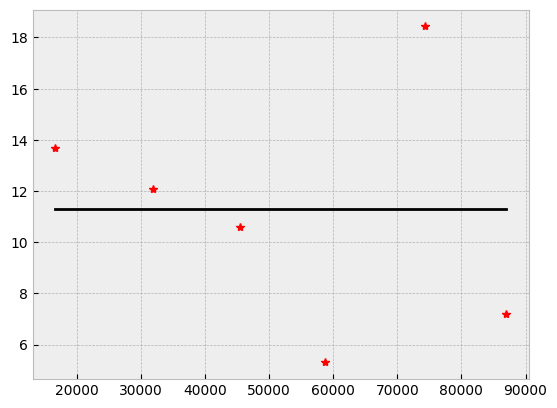

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...

PyKrige Kriging out-of-sample r-squared: nan
Root Mean Squared Error of prediction with Kriging is 1.7796267955627592


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [ ]:
TifExportUrl = '/content/drive/My Drive/Tif_Export/'
# Generate ordinary kriging object

OK = OrdinaryKriging(
    np.array(x_climatology),
    np.array(y_climatology),
    value_climatology,
    variogram_model = "exponential",
    verbose = True,
    enable_plotting = True,
    coordinates_type = "euclidean",
)
# linear, power, gaussian, spherical, exponential, hole-effect.
# Evaluate the method on grid
Z_pk_krig, sigma_squared_p_krig = OK.execute("grid", XX_pk_krig, YY_pk_krig)

# Export raster
export_kde_raster(Z = Z_pk_krig, XX = XX_pk_krig, YY = YY_pk_krig,
                  min_x = min_x_climatology, max_x = max_x_climatology, min_y = min_y_climatology, max_y = max_y_climatology,
                  proj = proj, filename = TifExportUrl + variableName +"_Map.tif")

# Open raster
raster_pk = rasterio.open( TifExportUrl + variableName + "_Map.tif")


# Create polygon with extent of raster
poly_shapely = box(*raster_pk.bounds)

# Create a dictionary with needed attributes and required geometry column
attributes_df = {'Attribute': ['name1'], 'geometry': poly_shapely}

# Convert shapely object to a GeoDataFrame
raster_pk_extent = gpd.GeoDataFrame(attributes_df, geometry = 'geometry', crs = proj)

# Create copy of test dataset
climatology_test_gdf_pk_krig = climatology_test_gdf.copy()

# Subset the GeoDataFrame by checking which test points are within the raster extent polygon
# If a test point is beyond the extent of training points dataset, the kriging output may not cover that test point
climatology_test_gdf_pk_krig = climatology_test_gdf_pk_krig[climatology_test_gdf_pk_krig.within(raster_pk_extent.geometry.values[0])]

# Create list of XY coordinate pairs for the test points that fall within raster extent polygon
coords_climatology_test_pk_krig = [list(xy) for xy in zip(climatology_test_gdf_pk_krig["geometry"].x, climatology_test_gdf_pk_krig["geometry"].y)]

# Extract raster value at each test point and add the values to the GeoDataFrame
climatology_test_gdf_pk_krig["VALUE_Predict"] = [x[0] for x in raster_pk.sample(coords_climatology_test_pk_krig)]

# Generate out-of-sample R^2
out_r_squared_tp = r2_score(climatology_test_gdf_pk_krig.Actual_Value, climatology_test_gdf_pk_krig.VALUE_Predict)
print("PyKrige Kriging out-of-sample r-squared: {}".format(round(out_r_squared_tp, 10)))
kriging_rmse = np.mean(np.sqrt((climatology_test_gdf_pk_krig['Actual_Value'] - np.array(climatology_test_gdf_pk_krig['VALUE_Predict']))**2))
print(f'Root Mean Squared Error of prediction with Kriging is {kriging_rmse}')


In [ ]:
# Display attribute table
print("\nAttribute Table: Random Points Interpolated Values - PyKrige Kriging Method")
display(climatology_test_gdf_pk_krig)
# Mask raster to counties shape
out_image_pk, out_transform_pk = rasterio.mask.mask(raster_pk, newcounties.geometry.values, crop = True)



Attribute Table: Random Points Interpolated Values - PyKrige Kriging Method


geometry  Actual_Value  VALUE_Predict
0  POINT (543847.877 3961751.285)      9.527845      11.307472

# plot

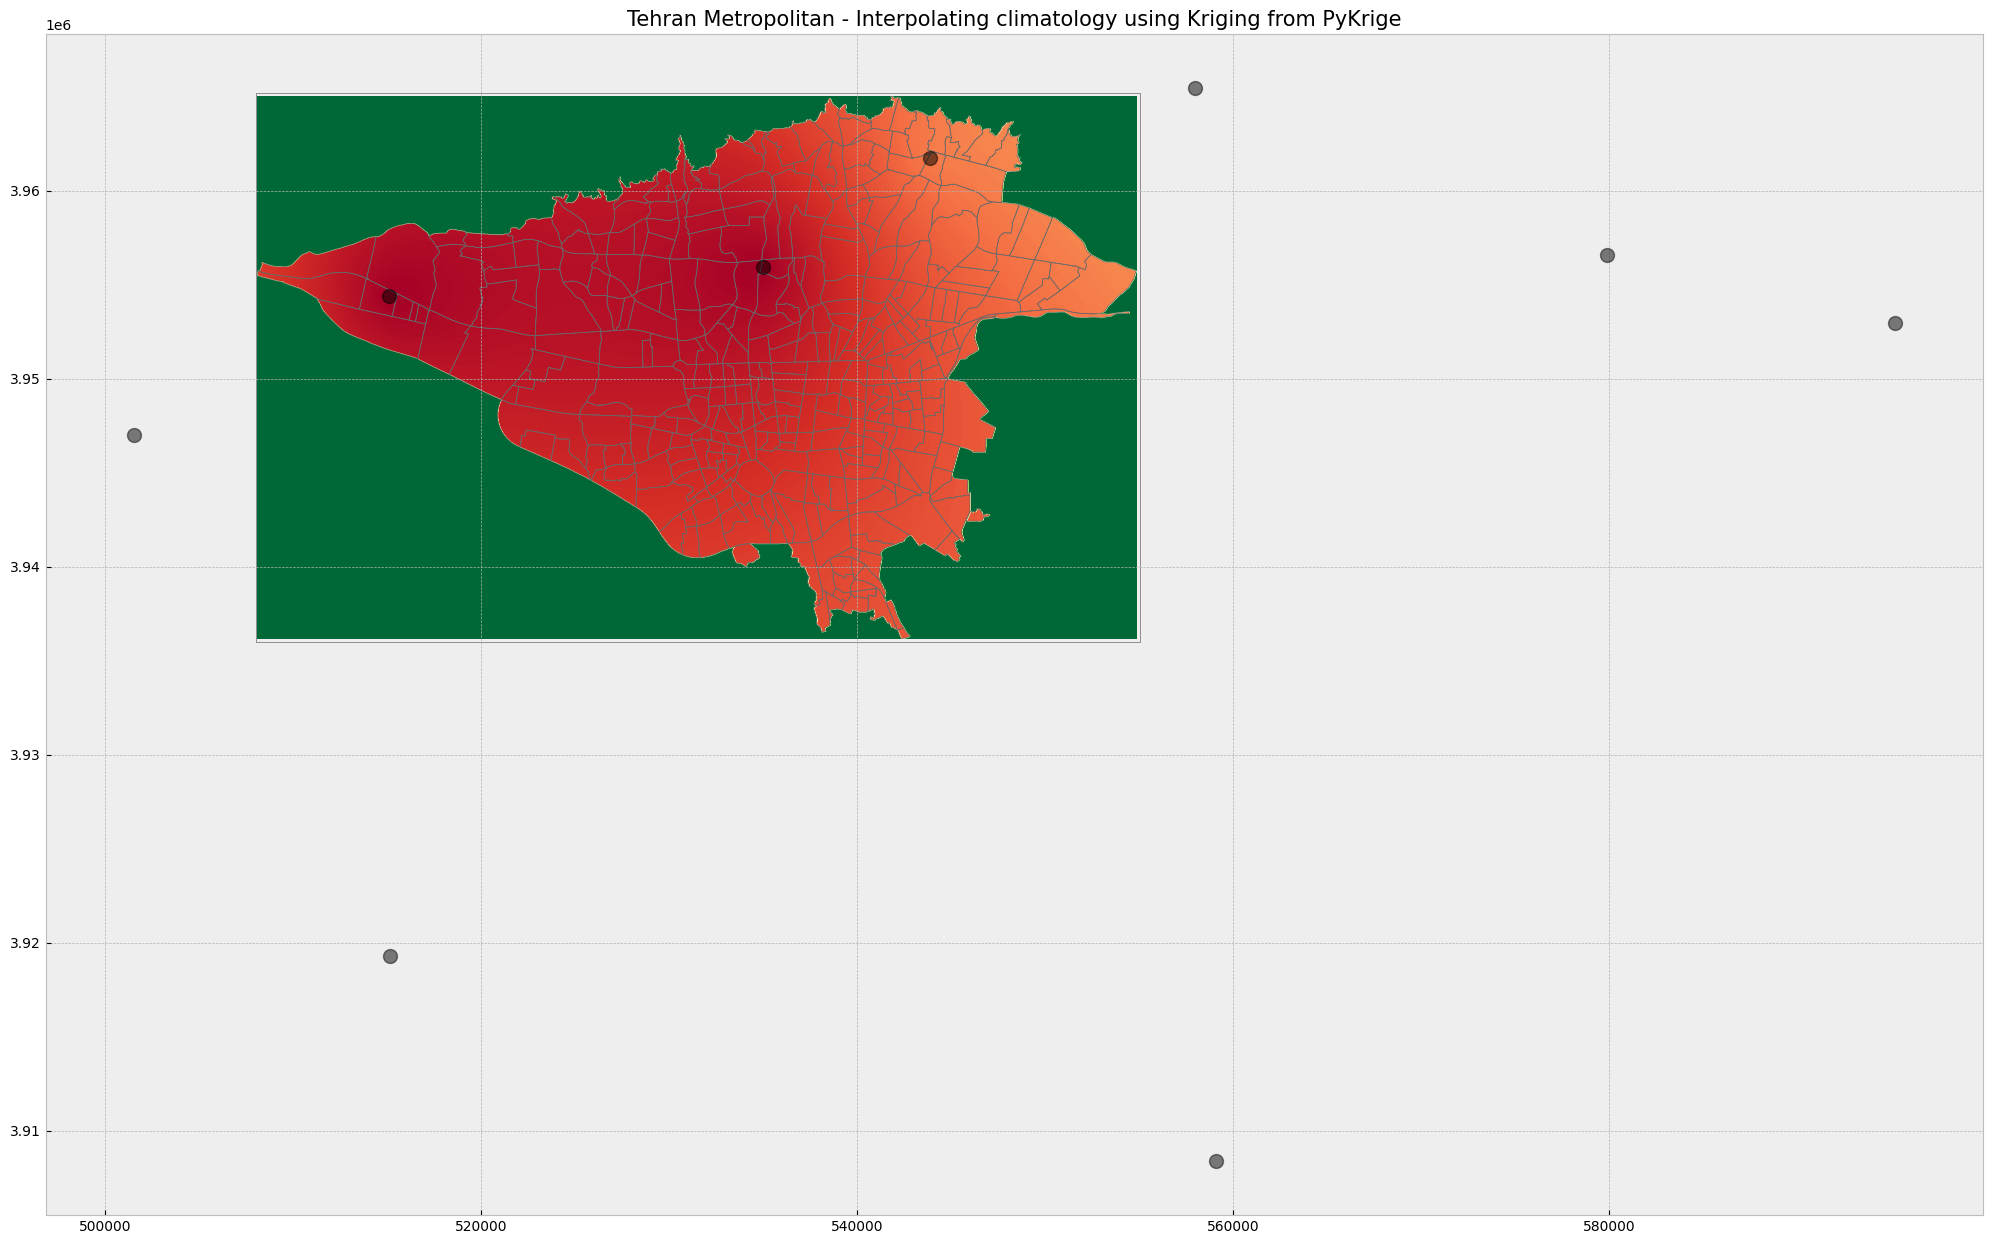

In [ ]:
# Stylize plots
plt.style.use('bmh')

# Plot data
#plt.figure(figsize=(25,20))
fig, ax = plt.subplots(1, figsize = (25, 20))
show(out_image_pk, ax = ax, transform = out_transform_pk, cmap = "RdYlGn_r", vmin=1, vmax=out_image_pk[0].max())
ax.plot(x_climatology, y_climatology, 'k.', markersize = 20, alpha = 0.5)
counties.plot(ax = ax, color = 'none', edgecolor = 'dimgray')
newcounties.plot(ax = ax, color = 'none', edgecolor = 'dimgray')
plt.gca().invert_yaxis()

# Set title
ax.set_title('Tehran Metropolitan - Interpolating climatology using Kriging from PyKrige', fontdict = {'fontsize': '15', 'fontweight' : '3'})

# Display plot
plt.show()

# Create All Maps

## export all

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 108720.67118915998
Full Sill: 108720.67118916291
Range: 50409.890436100395
Nugget: 2.929163833579121e-09 



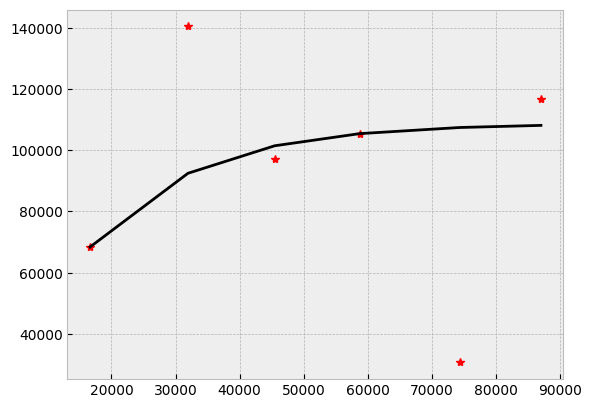

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 2378693.2821682016
Full Sill: 2378693.2823156044
Range: 86962.25051344614
Nugget: 0.00014740281149685543 



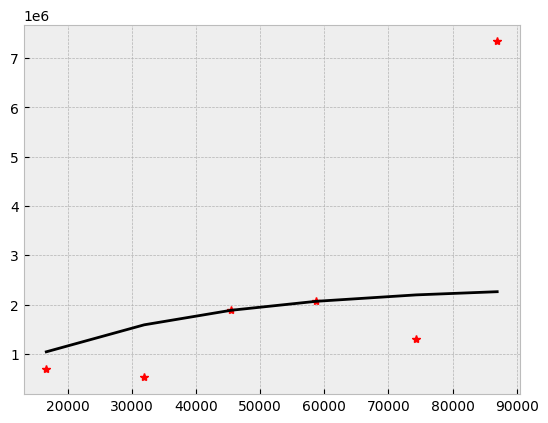

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 1.0316704710723528
Full Sill: 1.112093855480445
Range: 270.48134112527123
Nugget: 0.08042338440809213 



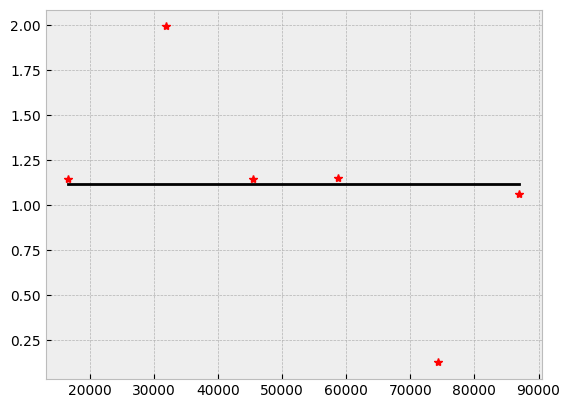

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 103.62406110188478
Full Sill: 1557.6968609879616
Range: 319.4118203232101
Nugget: 1454.0727998860768 



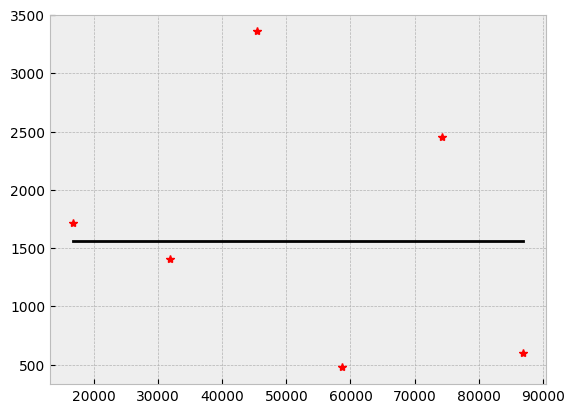

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 1.0477776682729592
Full Sill: 1.047777668272962
Range: 71384.6999889283
Nugget: 2.8519320376292594e-15 



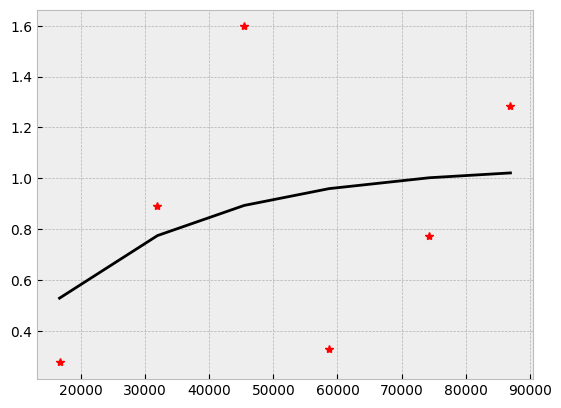

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 23.04868937683
Full Sill: 23.04868937683
Range: 86962.25051344401
Nugget: 2.0512093388688923e-25 



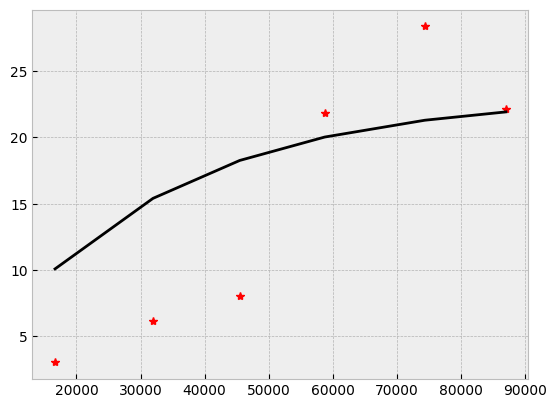

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 4.846719755028579
Full Sill: 4.846719755036158
Range: 86962.25051341695
Nugget: 7.578602910243552e-12 



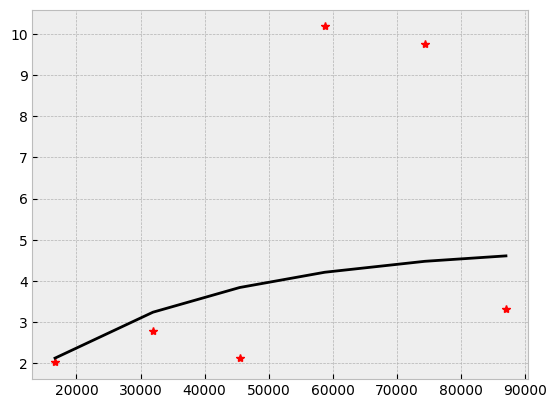

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 4142.556201125067
Full Sill: 4142.556201125067
Range: 86962.25051313076
Nugget: 3.18802802338458e-14 



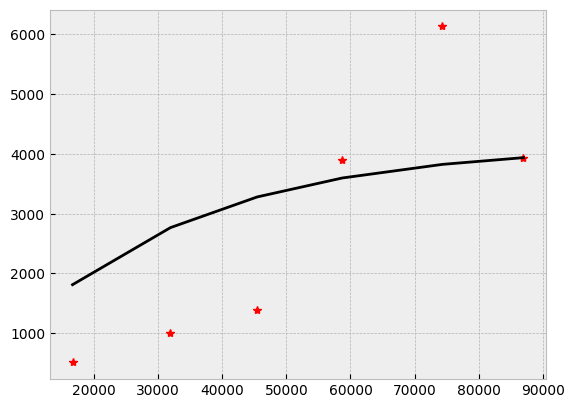

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.010888625210509444
Full Sill: 0.010888625210509444
Range: 86962.25051343527
Nugget: 2.0639236383976404e-19 



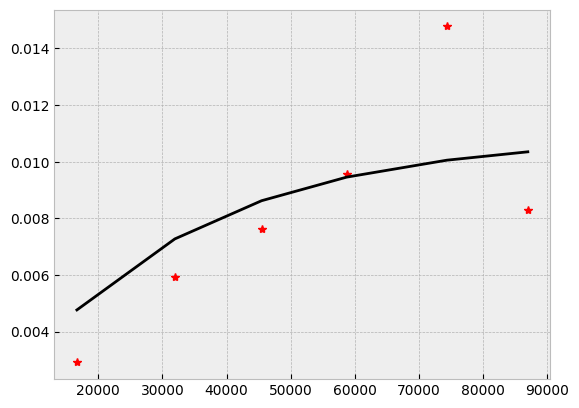

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 22.500213871364892
Full Sill: 22.500213871364892
Range: 86962.25051318524
Nugget: 1.4656685497491275e-16 



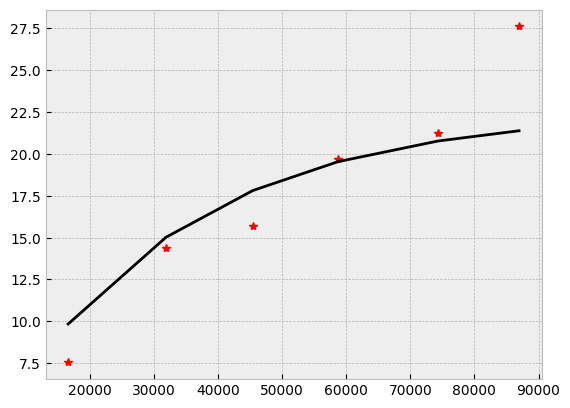

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 11.836257240720172
Full Sill: 11.836257240721274
Range: 86962.25051323562
Nugget: 1.1007133726725953e-12 



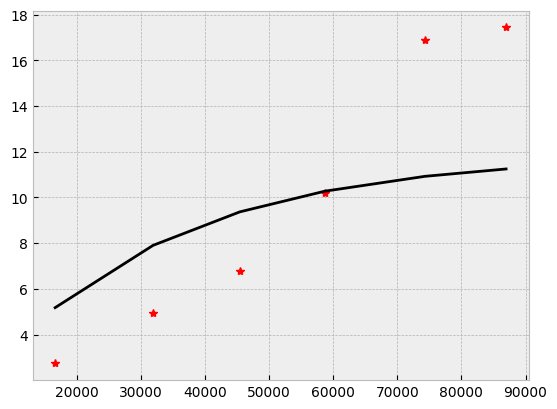

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 23.447540158328223
Full Sill: 23.447540158328223
Range: 86962.25051344228
Nugget: 1.890098775426733e-24 



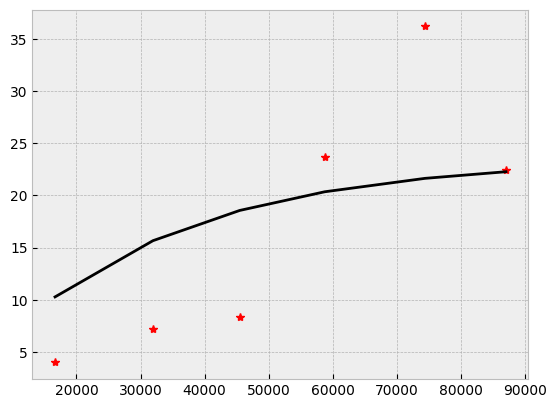

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 354366.795808017
Full Sill: 457279.94596924935
Range: 2166.436706544721
Nugget: 102913.1501612323 



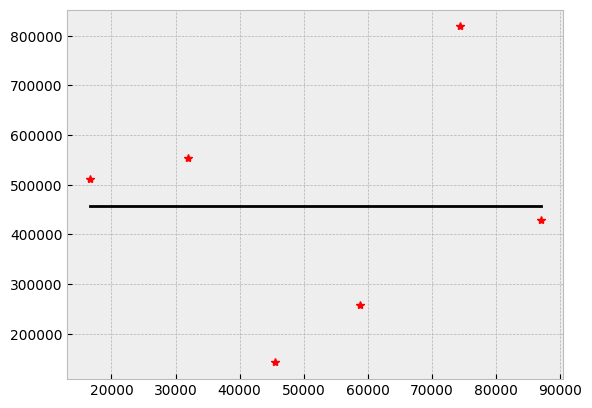

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 8.855752424114467
Full Sill: 8.855752424130195
Range: 86962.25051233753
Nugget: 1.572800340605606e-11 



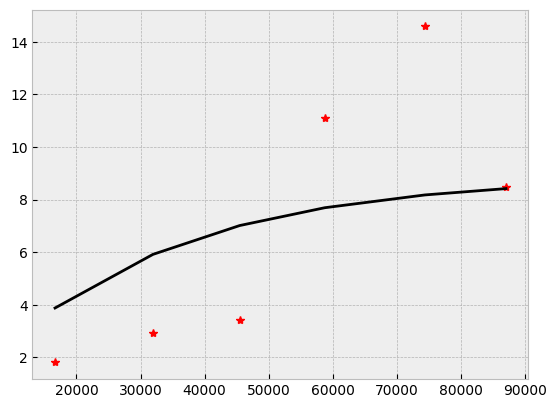

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.4053983786849133
Full Sill: 0.523804201683831
Range: 55.571292571672075
Nugget: 0.11840582299891773 



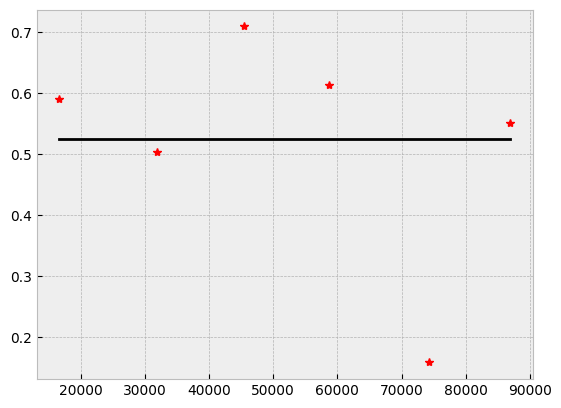

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 9.29803536610379e-25
Full Sill: 837.4819595824029
Range: 39419.41692048288
Nugget: 837.4819595824029 



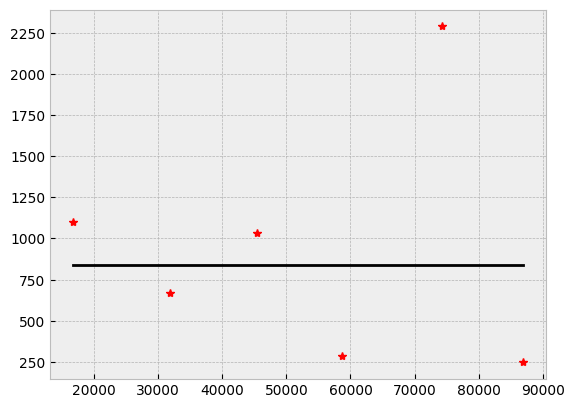

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 8.471679780219855
Full Sill: 11.28582227868334
Range: 72.88190259755766
Nugget: 2.814142498463486 



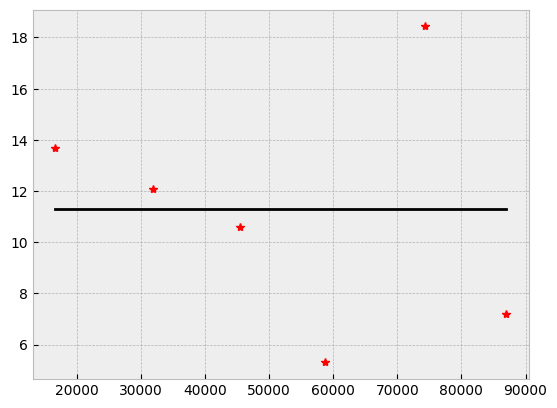

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 2026.6382228836183
Full Sill: 9831.761139722668
Range: 86962.25051154506
Nugget: 7805.122916839049 



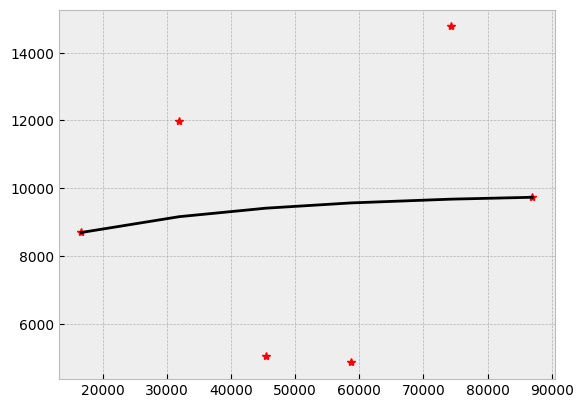

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



In [ ]:
TifExportUrl = '/content/drive/My Drive/Tif_Export/'
for i in range(len(climatologyDF.columns)):
  variableName = climatologyDF.columns[i]
  if(variableName == 'geometry'):
    continue
  value_climatology = list(climatologyGDF[variableName])
  OK = OrdinaryKriging(
    np.array(x_climatology),
    np.array(y_climatology),
    value_climatology,
    variogram_model = "exponential",
    verbose = True,
    enable_plotting = True,
    coordinates_type = "euclidean",
  )
  Z_pk_krig, sigma_squared_p_krig = OK.execute("grid", XX_pk_krig, YY_pk_krig)
  # Flip array vertically and rotate 270 degrees
#Z_sk_krig = np.rot90(np.flip(Z_sk_krig, 0), 3)
#where_0 = np.where(Z_sk_krig == 0)
#Z_sk_krig[where_0] = 1
  export_kde_raster(Z = Z_pk_krig, XX = XX_pk_krig, YY = YY_pk_krig,
                  min_x = min_x_climatology, max_x = max_x_climatology, min_y = min_y_climatology, max_y = max_y_climatology,
                  proj = proj, filename = TifExportUrl + variableName +"_Map.tif")

## Plot all in one figure

In [ ]:
ShapefilesURL='/content/drive/My Drive/ShapeFiles/'
boundingbox = gpd.read_file(ShapefilesURL+"BoundingBoxWithHole.shp")
boundingbox_wgs = boundingbox.to_crs(proj)

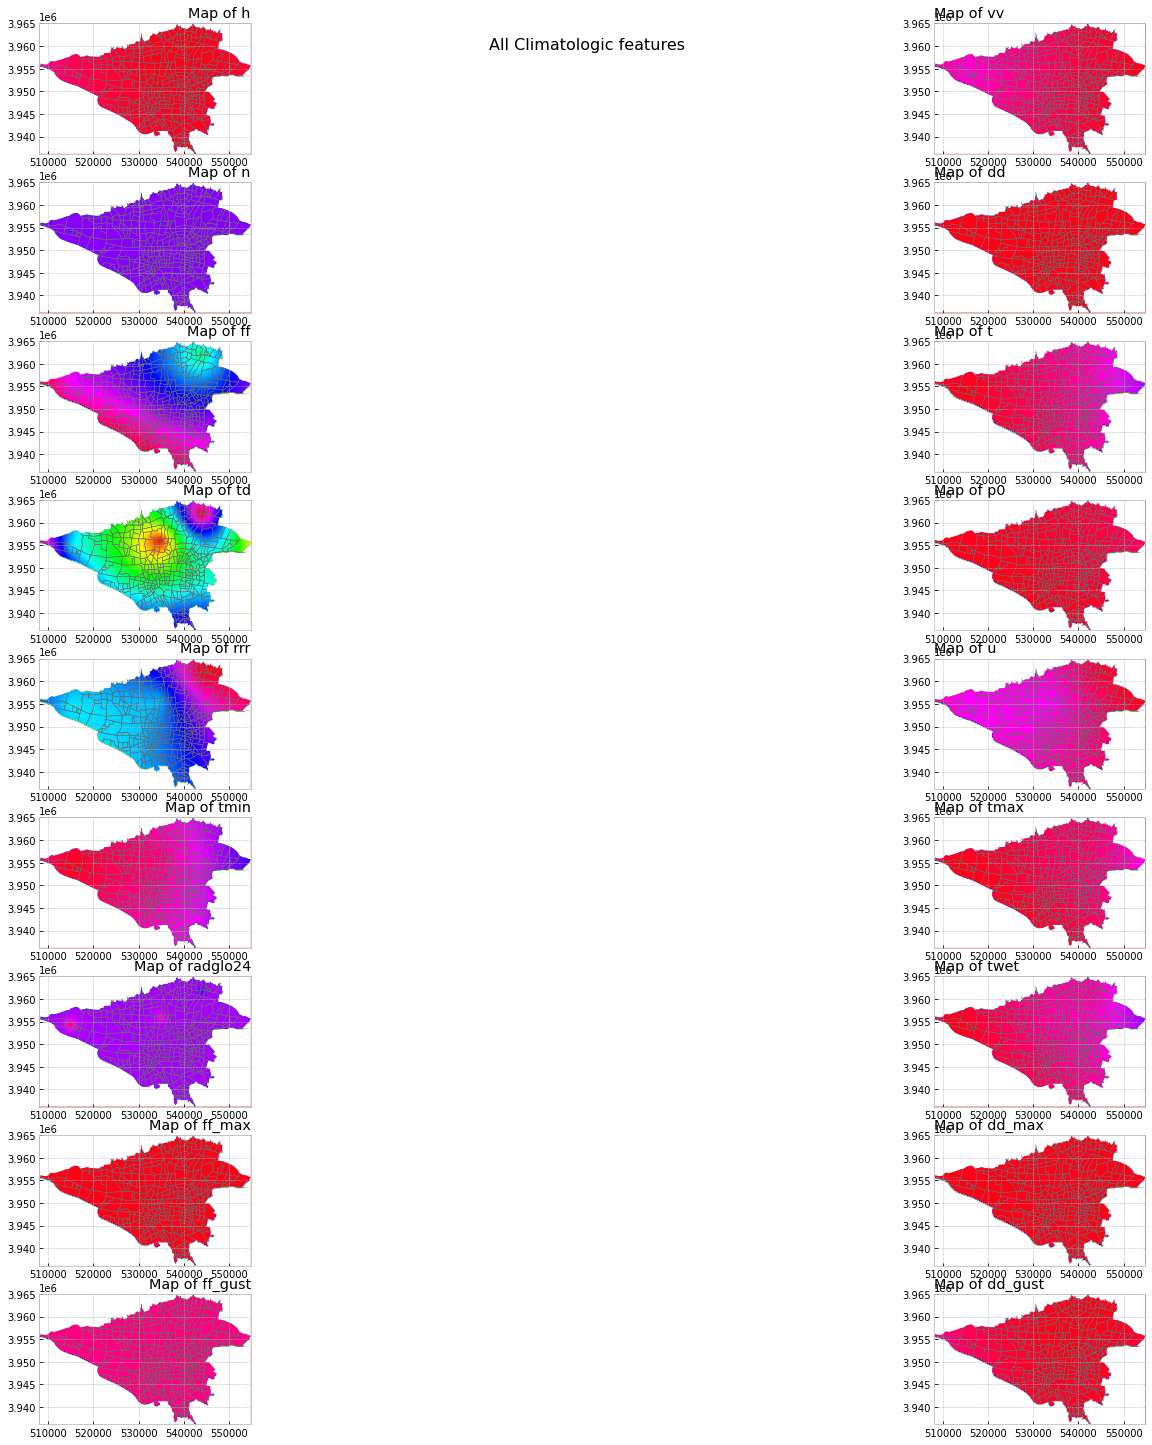

In [ ]:
import matplotlib.pyplot as plt
#plt.scatter(predictions['mantaghe22'],predictions['mantaghe22_imputed'])
fig, axes = plt.subplots(round(((len(climatologyDF.columns))-1)/2), 2,figsize = (25, 20), sharex=False, sharey=False)
#fig, axes = plt.subplots(round(((len(climatologyDF.columns))-1)/2), 2,figsize = (25, 20), constrained_layout=True, sharex=False, sharey=False)

    #fig.set_figheight(10)
    #fig.set_figwidth(15)
    #fig.supylabel('ug/m3', y=0.15, fontsize=14)
plt.style.use('bmh')
#axes = axes.flat
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace= None, hspace=None)
fig.suptitle("All Climatologic features", fontsize=16)
TifExportUrl = '/content/drive/My Drive/Tif_Export/'
for i in range(len(climatologyDF.columns)):
  variableName = climatologyDF.columns[i]
  if(variableName == 'geometry'):
    continue
  raster_pk = rasterio.open( TifExportUrl + variableName + "_Map.tif")
  out_image_pk, out_transform_pk = rasterio.mask.mask(raster_pk, counties.geometry.values, crop = True)
  if(i%2 == 0):
    show(out_image_pk, transform = out_transform_pk, ax = axes[round(i/2),0], cmap = "hsv", vmin=out_image_pk[0].min(), vmax=out_image_pk[0].max())
    axes[round(i/2),0].set_title("Map of "+variableName, loc='right', color='black' )
    counties.plot(ax = axes[round(i/2),0], color = 'none', edgecolor = 'dimgray')
    boundingbox_wgs.plot(ax = axes[round(i/2),0], color = 'white', edgecolor = 'none')
    axes[round(i/2),0].invert_yaxis()
   # axes[round(i/2),0].figure.set_size_inches(10, 15)

  else:
    show(out_image_pk, transform = out_transform_pk, ax =axes[round((i-1)/2),1], cmap = "hsv", vmin=out_image_pk[0].min(), vmax=out_image_pk[0].max())
    axes[round((i-1)/2),1].set_title("Map of "+variableName, loc='left', color='black' )
    counties.plot(ax = axes[round((i-1)/2),1], color = 'none', edgecolor = 'dimgray')
    boundingbox_wgs.plot(ax = axes[round((i-1)/2),1], color = 'white', edgecolor = 'none')
    axes[round((i-1)/2),1].invert_yaxis()
    #axes[round((i-1)/2),1].figure.set_size_inches(10, 10)

<ipython-input-35-78941388030c>:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plots[i] = plt.subplot(gridspec[i])
<ipython-input-35-78941388030c>:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plots[i] = plt.subplot(gridspec[i])
<ipython-input-35-78941388030c>:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plots[i] = plt.subplot(gridspec[i])
<ipython-input-35-78941388030c>:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plots[i] = plt.subplot(gridspec[i])
<ipython-input-3

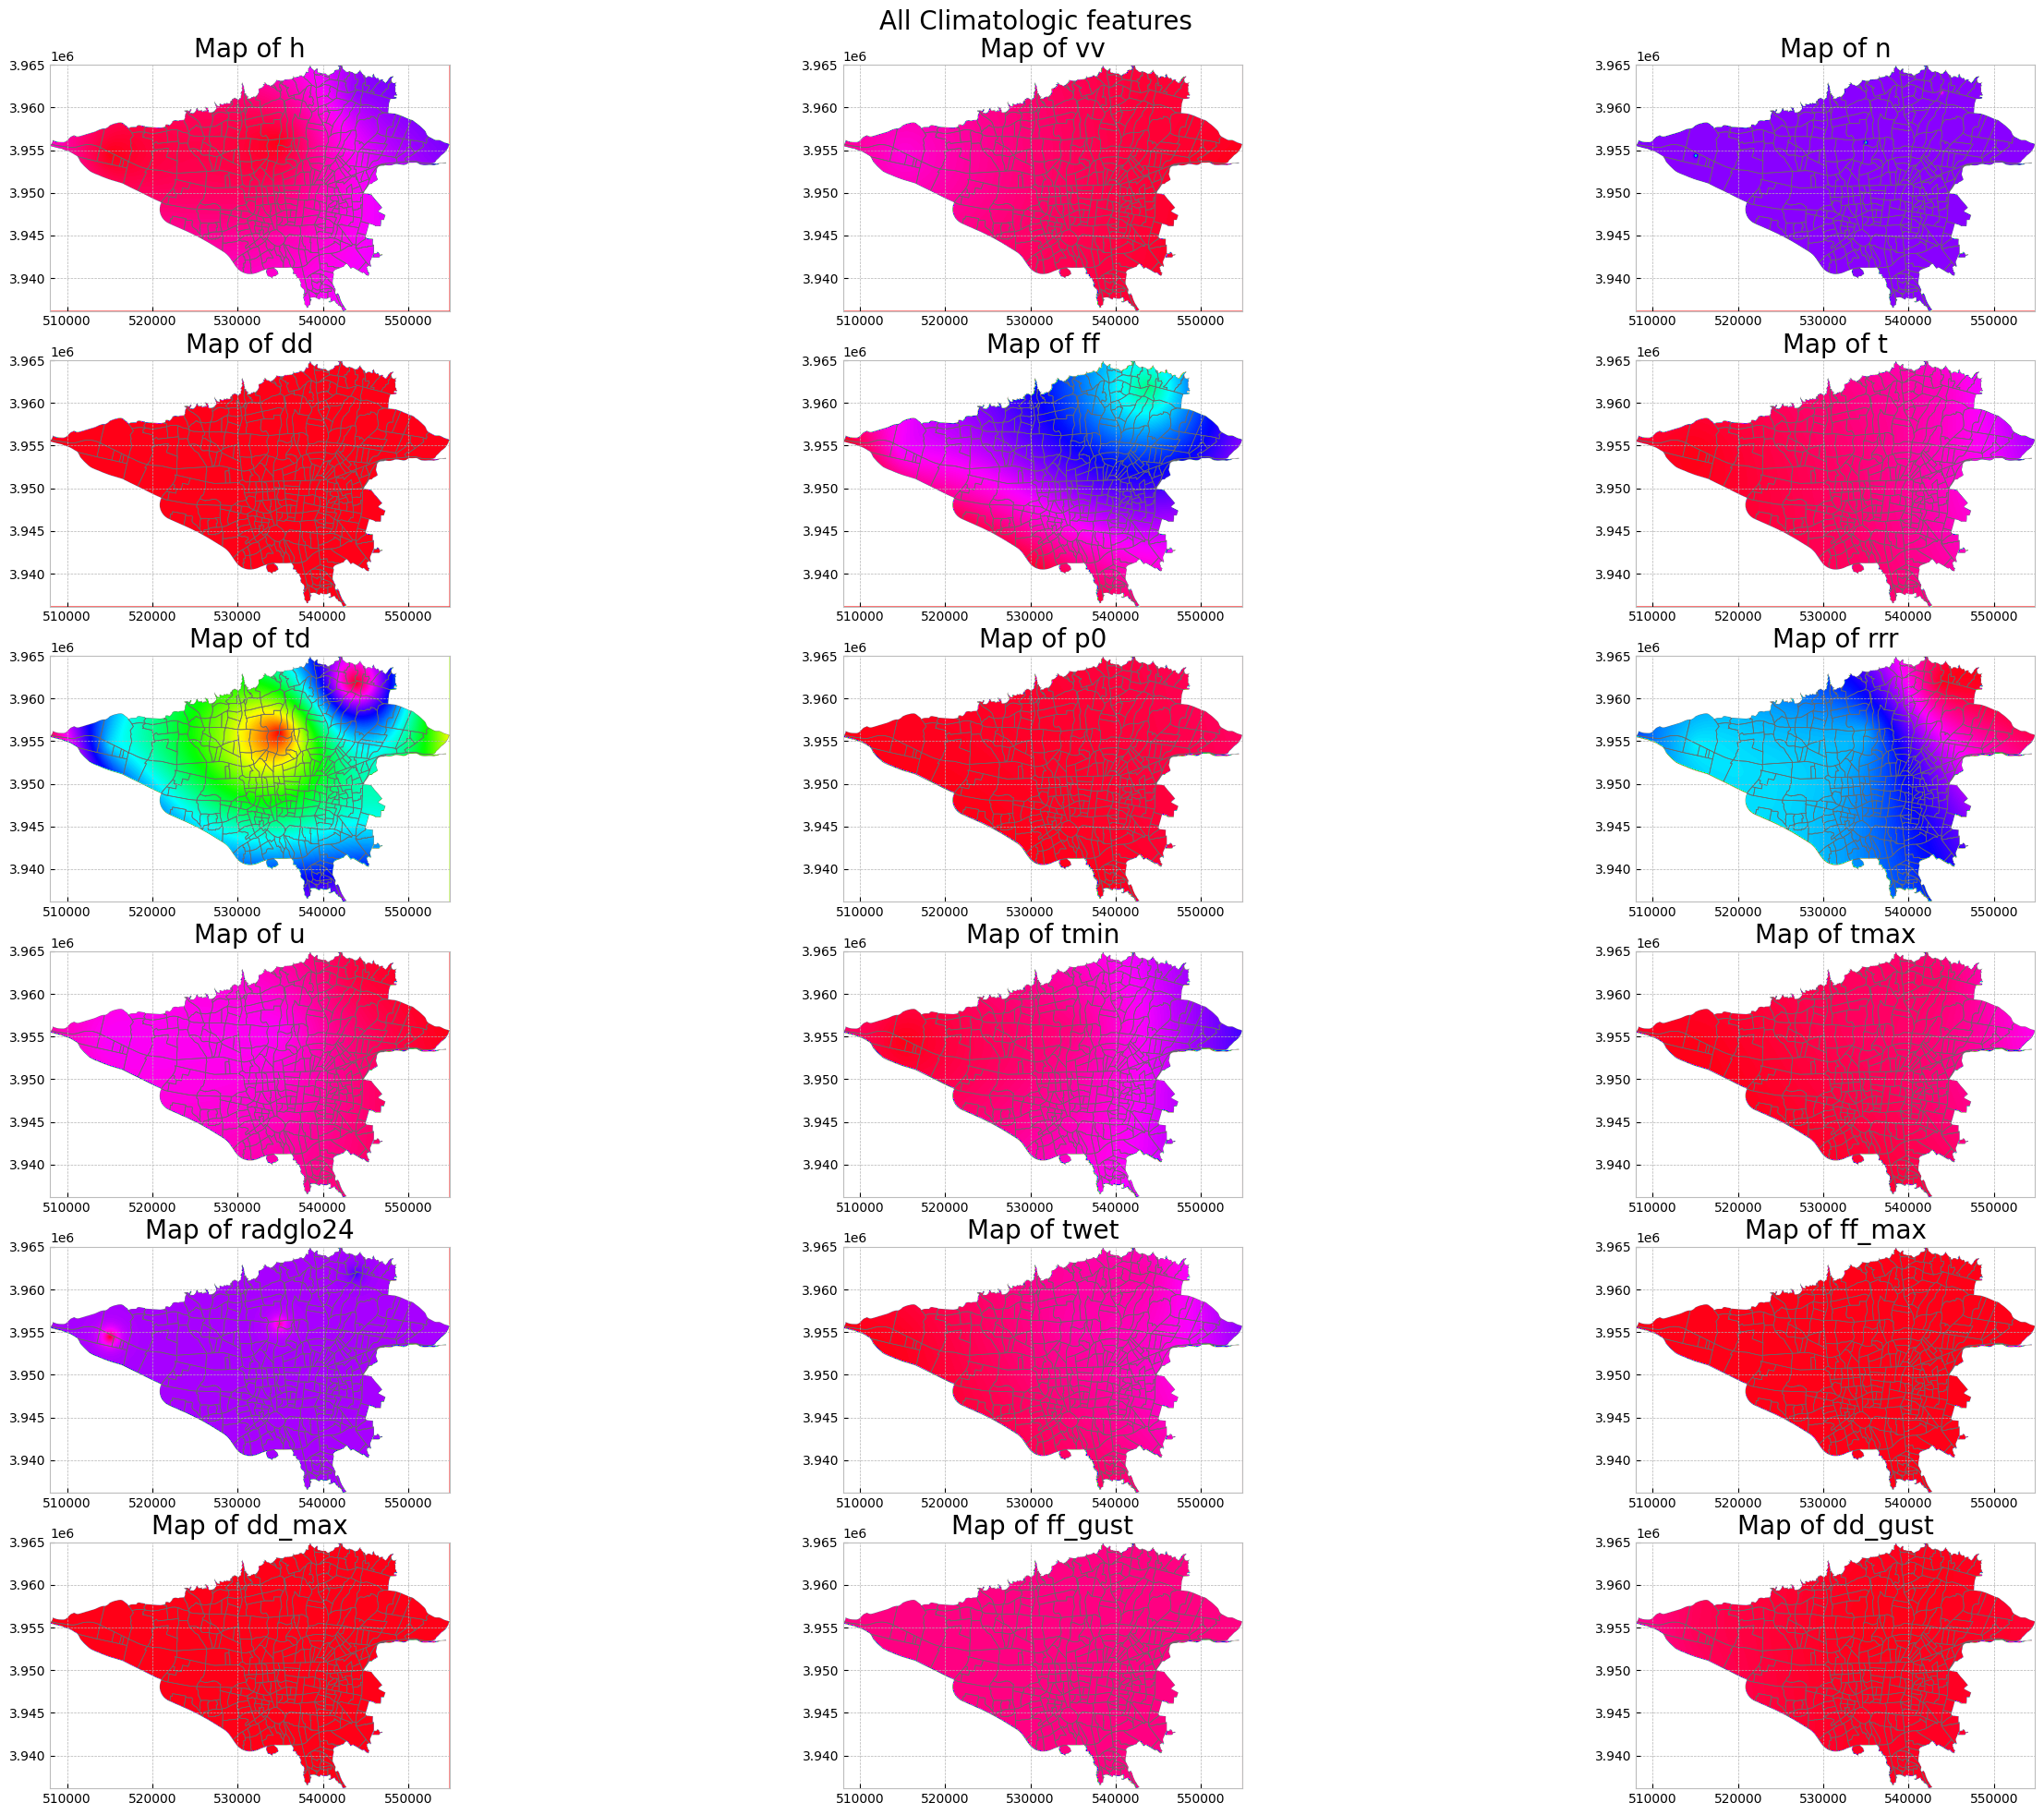

In [ ]:
from matplotlib.gridspec import GridSpec
ExportedJpegURL =  '/content/drive/My Drive/Exported_Jpeg/'
TifExportUrl = '/content/drive/My Drive/Tif_Export/'
figure, plots = plt.subplots(6, 3,figsize = (25, 20), sharex=False, sharey=False)
gridspec = GridSpec(6, 3)
figure.tight_layout()
plots = plots.flatten()
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace= None, hspace=None)
figure.suptitle("All Climatologic features", fontsize=20)
figure.subplots_adjust(top=0.95, wspace= 0.2, hspace=0.2)
for i in range(len(climatologyDF.columns)):
     variableName = climatologyDF.columns[i]
     if(variableName == 'geometry'):
       continue
     plots[i] = plt.subplot(gridspec[i])
     raster_pk = rasterio.open( TifExportUrl + variableName + "_Map.tif")
     out_image_pk, out_transform_pk = rasterio.mask.mask(raster_pk, newcounties.geometry.values, crop = True)
     show(out_image_pk, transform = out_transform_pk, ax = plots[i], cmap = "hsv", vmin=out_image_pk[0].min(), vmax=out_image_pk[0].max())
     plots[i].set_title("Map of "+variableName, loc='center', color='black', fontsize=20 )
     newcounties.plot(ax = plots[i], color = 'none', edgecolor = 'dimgray')
     boundingbox_wgs.plot(ax = plots[i], color = 'white', edgecolor = 'none')
     plots[i].invert_yaxis()
plt.savefig(ExportedJpegURL+'Climatology_Mean.jpg')

# Resample and crop

check all raster are same crs with shape

In [ ]:
raster_pk = rasterio.open( TifExportUrl + "h" + "_Map.tif")
display(raster_pk.crs)

CRS.from_epsg(32639)

In [ ]:
counties.crs

<Projected CRS: EPSG:32639>
Name: WGS 84 / UTM zone 39N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 48°E and 54°E, northern hemisphere between equator and 84°N, onshore and offshore. Azerbaijan. Bahrain. Islamic Republic of Iran. Iraq. Kazakhstan. Kuwait. Oman. Qatar. Russian Federation. Saudi Arabia. Somalia. Turkmenistan. United Arab Emirates. Yemen.
- bounds: (48.0, 0.0, 54.0, 84.0)
Coordinate Operation:
- name: UTM zone 39N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Resample and crop

In [ ]:
new_cell_size = 20
for i in range(len(climatologyDF.columns)):
 variableName = climatologyDF.columns[i]
 if(variableName == 'geometry'):
    continue
 #--------------------RESAMPLE--------------------
 with rasterio.open(TifExportUrl + variableName + "_Map.tif") as src:

    # Calculate the new dimensions of the output raster based on the desired cell size
    width = int(src.width * src.res[0] / new_cell_size)
    height = int(src.height * src.res[1] / new_cell_size)

    # Calculate the new geotransform of the output raster
    transform = rasterio.Affine(src.transform.a / (src.res[0] / new_cell_size), src.transform.b, src.transform.c,
                                src.transform.d, src.transform.e / (src.res[1] / new_cell_size), src.transform.f)
    # Create the output raster dataset with the new dimensions and geotransform
    meta = src.meta.copy()
    meta.update({
        'width': width,
        'height': height,
        'transform': transform,
    })
    with rasterio.open(TifExportUrl + variableName + "_Map.tif", 'w', **meta) as dst:
      for i in range(1, src.count + 1):
            raster = src.read(i, out_shape=(src.count, height, width))
            dst.write(raster, i)

In [ ]:
new_cell_size = 20
for i in range(len(climatologyDF.columns)):
 variableName = climatologyDF.columns[i]
 if(variableName == 'geometry'):
    continue
 #--------------------RESAMPLE--------------------
 with rasterio.open(TifExportUrl + variableName + "_Map.tif") as src:

    # Calculate the new dimensions of the output raster based on the desired cell size
    width = int(src.width * src.res[0] / new_cell_size)
    height = int(src.height * src.res[1] / new_cell_size)

    # Calculate the new geotransform of the output raster
    transform = rasterio.Affine(src.transform.a / (src.res[0] / new_cell_size), src.transform.b, src.transform.c,
                                src.transform.d, src.transform.e / (src.res[1] / new_cell_size), src.transform.f)
    # Create the output raster dataset with the new dimensions and geotransform
    meta = src.meta.copy()
    meta.update({
        'width': width,
        'height': height,
        'transform': transform,
    })
    with rasterio.open(TifExportUrl + variableName + "_MapResampleAndCrop.tif", 'w', **meta) as dst:
      for i in range(1, src.count + 1):
            raster = src.read(i, out_shape=(src.count, height, width))
            dst.write(raster, i)
    # -------------- CROP --------------------------
 raster_pk = rasterio.open( TifExportUrl + variableName + "_MapResampleAndCrop.tif")
 out_image_pk, out_transform_pk = rasterio.mask.mask(raster_pk, counties.geometry.values, crop = True)
 out_meta = raster_pk.meta
 out_meta.update({"driver": "GTiff",
                 "height": out_image_pk.shape[1],
                 "width": out_image_pk.shape[2],
                 "transform": out_transform_pk})
 with rasterio.open(TifExportUrl + variableName + "_MapResampleAndCrop.tif", "w", **out_meta) as dest:
      dest.write(out_image_pk)

test

In [ ]:
raster_pk = rasterio.open( TifExportUrl + "ff" + "_Map.tif")
out_image_pk, out_transform_pk = rasterio.mask.mask(raster_pk, counties.geometry.values, crop = True)
print('shape: ')
print(raster_pk.shape)
print('max: ')
print( out_image_pk.max())
print('min: ')
print( out_image_pk.min())
pixelSizeX, pixelSizeY  = raster_pk.res
print('pixelSizeX: ')
print(pixelSizeX)
print('pixelSizeY: ')
print(pixelSizeY)

shape: 
(1444, 2340)
max: 
2.3469867515471003
min: 
0.0
pixelSizeX: 
20.0
pixelSizeY: 
20.0


In [ ]:
import rasterio
TifExportUrl = '/content/drive/My Drive/Tif_Export/'

In [ ]:
raster_pk = rasterio.open( TifExportUrl + "ff" + "_Map.tif")
display(raster_pk.crs)
print('shape: ')
print(raster_pk.shape)
out_image_pk, out_transform_pk = rasterio.mask.mask(raster_pk, counties.geometry.values, crop = True)
print('max: ')
print( out_image_pk.max())
print('min: ')
print( out_image_pk.min())
pixelSizeX, pixelSizeY  = raster_pk.res
print('pixelSizeX: ')
print(pixelSizeX)
print('pixelSizeY: ')
print(pixelSizeY)

CRS.from_epsg(32639)

shape: 
(4500, 4500)
max: 
2.3478018599875394
min: 
0.0
pixelSizeX: 
17.412408259159548
pixelSizeY: 
12.692676008164883


In [ ]:
new_cell_size = 20
with rasterio.open(TifExportUrl + "ff" + "_Map.tif") as src:

    # Calculate the new dimensions of the output raster based on the desired cell size
    width = int(src.width * src.res[0] / new_cell_size)
    height = int(src.height * src.res[1] / new_cell_size)

    # Calculate the new geotransform of the output raster
    transform = rasterio.Affine(src.transform.a / (src.res[0] / new_cell_size), src.transform.b, src.transform.c,
                                src.transform.d, src.transform.e / (src.res[1] / new_cell_size), src.transform.f)
    # Create the output raster dataset with the new dimensions and geotransform
    meta = src.meta.copy()
    meta.update({
        'width': width,
        'height': height,
        'transform': transform,
    })
    with rasterio.open(TifExportUrl + "ff" + "_MapResample.tif", 'w', **meta) as dst:
      for i in range(1, src.count + 1):
            raster = src.read(i, out_shape=(src.count, height, width))
            dst.write(raster, i)

In [ ]:
raster_pk = rasterio.open(TifExportUrl + "ff" + "_MapResample.tif")
display(raster_pk.crs)
print('shape: ')
print(raster_pk.shape)
out_image_pk, out_transform_pk = rasterio.mask.mask(raster_pk, counties.geometry.values, crop = True)
print('max: ')
print( out_image_pk.max())
print('min: ')
print( out_image_pk.min())
pixelSizeX, pixelSizeY  = raster_pk.res
print('pixelSizeX: ')
print(pixelSizeX)
print('pixelSizeY: ')
print(pixelSizeY)

CRS.from_epsg(32639)

shape: 
(2855, 3917)
max: 
2.3469867515471003
min: 
0.0
pixelSizeX: 
20.0
pixelSizeY: 
20.0


In [ ]:
out_image_pk, out_transform_pk = rasterio.mask.mask(raster_pk, counties.geometry.values, crop = True)
out_meta = raster_pk.meta

out_meta.update({"driver": "GTiff",
                 "height": out_image_pk.shape[1],
                 "width": out_image_pk.shape[2],
                 "transform": out_transform_pk})
display(out_image_pk)

with rasterio.open(TifExportUrl + "ff" + "_MapCrop.tif", "w", **out_meta) as dest:
    dest.write(out_image_pk)

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [ ]:
raster_pk = rasterio.open( TifExportUrl + "ff" + "_MapCrop.tif")
out_image_pk, out_transform_pk = rasterio.mask.mask(raster_pk, counties.geometry.values, crop = True)
print('shape: ')
print(raster_pk.shape)
print('max: ')
print( out_image_pk.max())
print('min: ')
print( out_image_pk.min())
pixelSizeX, pixelSizeY  = raster_pk.res
print('pixelSizeX: ')
print(pixelSizeX)
print('pixelSizeY: ')
print(pixelSizeY)


shape: 
(1444, 2340)
max: 
2.3469867515471003
min: 
0.0
pixelSizeX: 
20.0
pixelSizeY: 
20.0


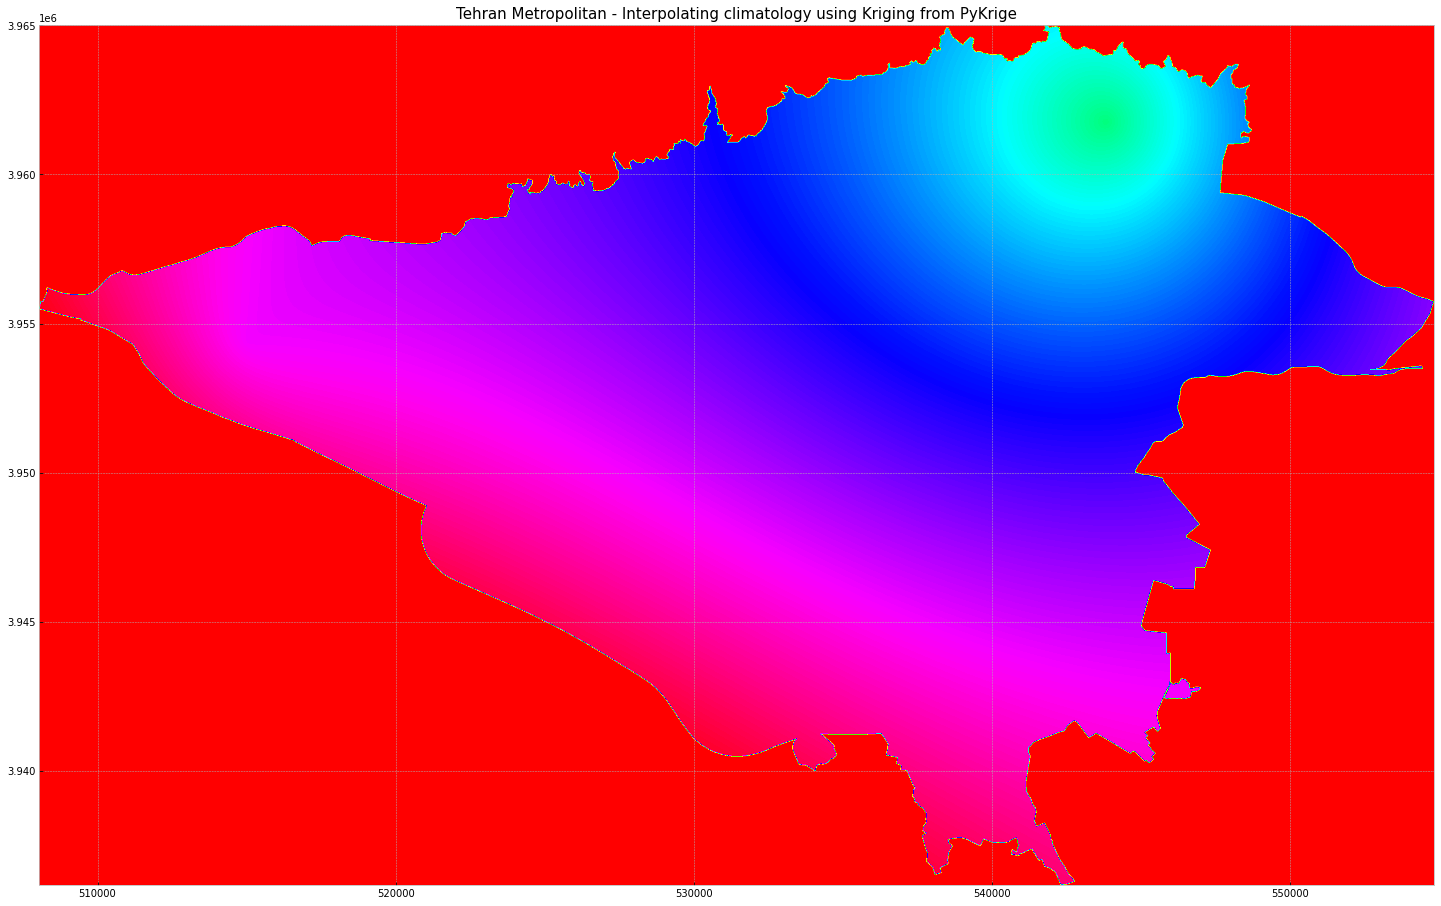

In [ ]:
raster_pk = rasterio.open(TifExportUrl + "ff" + "_Map.tif")

# Stylize plots
plt.style.use('bmh')

# Plot data
#plt.figure(figsize=(25,20))
fig, ax = plt.subplots(1, figsize = (25, 20))
#plt.imshow(raster_pk.read(1), cmap='pink')
show(out_image_pk, ax = ax, transform = out_transform_pk, cmap = "hsv")
#ax.plot(x_climatology, y_climatology, 'k.', markersize = 20, alpha = 0.5)
#counties.plot(ax = ax, color = 'none', edgecolor = 'dimgray')
plt.gca().invert_yaxis()

# Set title
ax.set_title('Tehran Metropolitan - Interpolating climatology using Kriging from PyKrige', fontdict = {'fontsize': '15', 'fontweight' : '3'})

# Display plot
plt.show()